In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trainvlg/train.csv


In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize,differential_evolution
from scipy.stats import norm
#preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
#models
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
#evaluation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
#hyperopt
from hyperopt import hp, tpe, Trials, fmin
from hyperopt.pyll.base import scope

In [84]:
def model_score(params, model_name, X, y):
    if model_name == 'XGBoost':
        n_estimators, max_depth, learning_rate = params
        model = XGBClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
    elif model_name == 'GradientBoosting':
        n_estimators, max_depth, learning_rate = params
        model = GradientBoostingClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
    elif model_name == 'AdaBoost':
        n_estimators, learning_rate = params
        model = AdaBoostClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, random_state=42)

    score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
    return -score

In [85]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    sigma = sigma.reshape(-1, 1)
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        final = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        final[sigma == 0.0] = 0.0
    return final

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    dim = X_sample.shape[1]
    def min_obj(X):
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    result = differential_evolution(min_obj, bounds, strategy='best1bin', maxiter=100, popsize=15, tol=1e-6)    
    return result.x.reshape(1, -1)

In [86]:
model_dict = {
        'XGBoost': np.array([[10, 20], [10, 20], [0.01, 0.1]]),        
        'GradientBoosting': np.array([[10, 20], [10, 20], [0.01, 0.1]]),
        'AdaBoost': np.array([[10, 20], [0.01, 0.1]]),
    }

In [100]:
def optimize(model_name, X, y):
    bounds = model_dict[model_name]
    np.random.seed(42)
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(5, bounds.shape[0]))
    Y_sample = np.array([model_score(params, model_name, X, y) for params in X_sample]).reshape(-1, 1)
    
    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=10, normalize_y=True)
    n_iterations = 10
    accuracies = [] 
    
    for i in range(n_iterations):
        gpr.fit(X_sample, Y_sample)
        next_sample = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
        next_value = model_score(next_sample[0], model_name, X, y)
        learning_rate= next_sample[0][-1]
        if model_name == 'XGBoost':
            model = XGBClassifier(n_estimators=int(next_sample[0][0]), max_depth=int(next_sample[0][1]), learning_rate=learning_rate, random_state=42)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(n_estimators=int(next_sample[0][0]), max_depth=int(next_sample[0][1]), learning_rate=learning_rate, random_state=42)
        elif model_name == 'AdaBoost':
            model = AdaBoostClassifier(n_estimators=int(next_sample[0][0]),  learning_rate=learning_rate, random_state=42 )
        
        accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        accuracies.append(accuracy)  
        X_sample = np.vstack((X_sample, next_sample))
        Y_sample = np.vstack((Y_sample, np.array(next_value).reshape(-1, 1)))
    
    best_index = np.argmin(Y_sample)
    best_params = X_sample[best_index]
    optimized_accuracy = -np.min(Y_sample)
    accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()

    y_pred = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1] 
    roc_auc = roc_auc_score(y, y_pred) 
    return {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'accuracies': accuracies
    }

In [101]:
def plot_accuracy( accuracies):
    iterations = range(1, len(accuracies) + 1)  
    plt.plot(iterations, accuracies, label='Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title('Accuracy vs Iteration')
    plt.show()

In [102]:
def preprocess(model_name, dataset, target_column):
    data = pd.read_csv(dataset, nrows=5000)
    X = data.drop(columns=[target_column])
    y = data[target_column]
    le = LabelEncoder()
    y = le.fit_transform(y)

    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    X_preprocessed = preprocessor.fit_transform(X)
    return X_preprocessed, y

In [103]:
def automl(model_name, dataset, target_column):
    x_new,y_new = preprocess(model_name,dataset, target_column)
    results = optimize(model_name, x_new, y_new)
    accuracies= results['accuracies']
    plot_accuracy( accuracies)
    print(f"   Accuracy: {results['accuracy']}")
    print(f" ROC-AUC: {results['roc_auc']}")

In [104]:
def optimize_new(model_name, X, y):
    # Define the hyperparameter space
    space = {
        'XGBoost': {
            'n_estimators': scope.int(hp.quniform('n_estimators', 10, 20, 1)),
            'max_depth': scope.int(hp.quniform('max_depth', 10, 20, 1)),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.1)
        },
        'GradientBoosting': {
            'n_estimators': scope.int(hp.quniform('n_estimators', 10, 20, 1)),
            'max_depth': scope.int(hp.quniform('max_depth', 10, 20, 1)),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.1)
        },
        'AdaBoost': {
            'n_estimators': scope.int(hp.quniform('n_estimators', 10, 20, 1)),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.1)
        },
    }

    # Define the model classes
    model_classes = {
        'XGBoost': XGBClassifier,
        'GradientBoosting': GradientBoostingClassifier,
        'AdaBoost': AdaBoostClassifier
    }  
    accuracies = [] 

    # Objective function for Hyperopt
    def objective_hyperopt(params):
        model = model_classes[model_name](**params, random_state=42)
        score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        
        if 'learning_rate' in params:
            accuracies.append(score)
        return -score

    # Hyperparameter optimization
    trials = Trials()
    best_params = fmin(objective_hyperopt, space[model_name], algo=tpe.suggest, max_evals=20, trials=trials)

    # Convert best_params values to correct types
    best_params = {key: int(value) if key in ['n_estimators', 'max_depth'] else value for key, value in best_params.items()}
    best_score = -trials.best_trial['result']['loss']

    # Fit the best model
    best_model = model_classes[model_name](**best_params, random_state=42)
    best_model.fit(X, y)    
    accuracy = cross_val_score(best_model, X, y, cv=5, scoring='accuracy').mean()

    y_pred = cross_val_predict(best_model, X, y, cv=5, method='predict_proba')[:, 1]
    roc_auc = roc_auc_score(y, y_pred)
    
    return {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'accuracies': accuracies
    }

In [92]:
def automl_new(model_name, dataset, target_column):
    x_new, y_new= preprocess(model_name, dataset, target_column)
    result = optimize_new(model_name,x_new, y_new)
    accuracies= result['accuracies']
    plot_accuracy( accuracies)
    print(f"   Accuracy: {result['accuracy']}")
    print(f" ROC-AUC: {result['roc_auc']}")

In [96]:
df= pd.read_csv('/kaggle/input/trainvlg/train.csv')
df.head(2)
import warnings
warnings.filterwarnings('ignore')

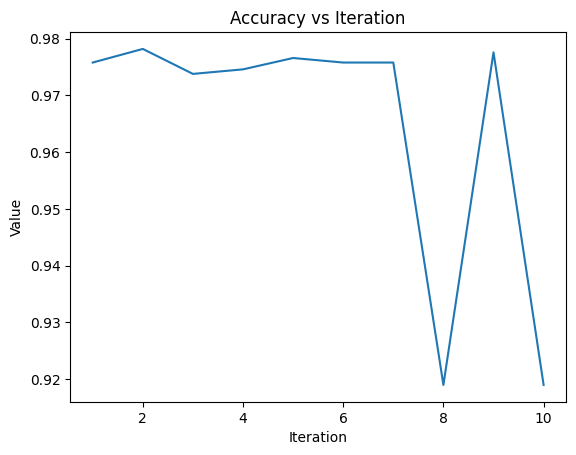

   Accuracy: 0.9190000000000002
 ROC-AUC: 0.9263372694420935
100%|██████████| 20/20 [01:52<00:00,  5.63s/trial, best loss: -0.9766]


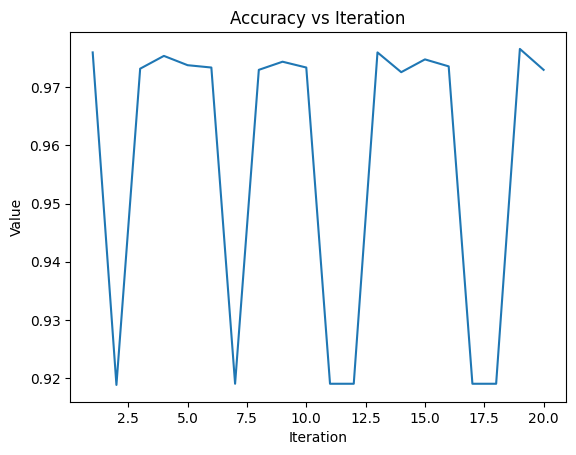

   Accuracy: 0.9766
 ROC-AUC: 0.9885691640134876


In [97]:
automl("GradientBoosting", "/kaggle/input/trainvlg/train.csv","credit_card_default")
automl_new("GradientBoosting", "/kaggle/input/trainvlg/train.csv","credit_card_default")

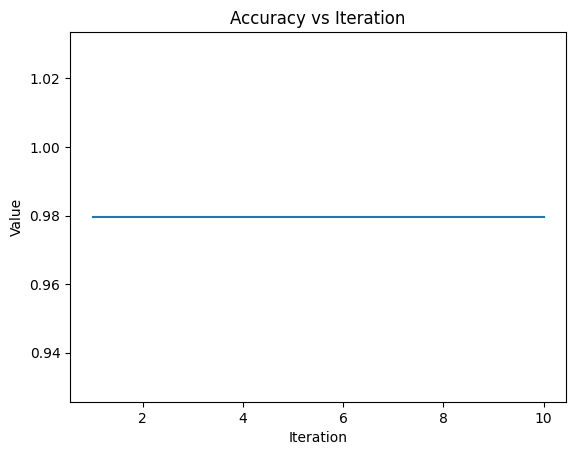

   Accuracy: 0.9795999999999999
 ROC-AUC: 0.9928166686817393
100%|██████████| 20/20 [01:12<00:00,  3.61s/trial, best loss: -0.9795999999999999]


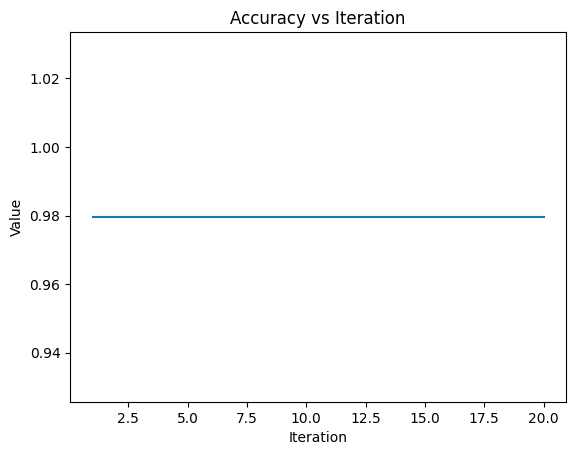

   Accuracy: 0.9795999999999999
 ROC-AUC: 0.9926460591894034


In [105]:
automl("AdaBoost", "/kaggle/input/trainvlg/train.csv","credit_card_default")
automl_new("AdaBoost", "/kaggle/input/trainvlg/train.csv","credit_card_default")

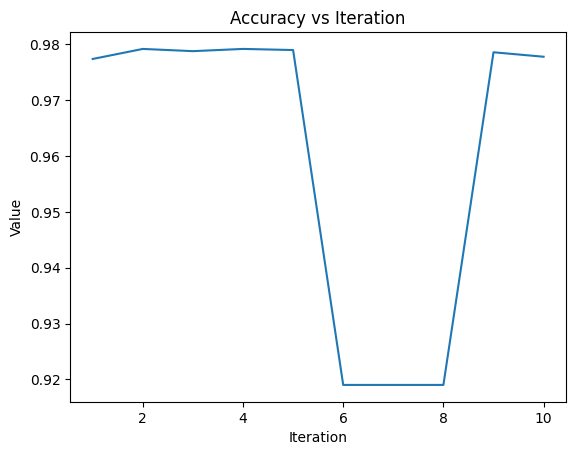

   Accuracy: 0.9778
 ROC-AUC: 0.9939099128145192
100%|██████████| 20/20 [00:18<00:00,  1.08trial/s, best loss: -0.9794]            


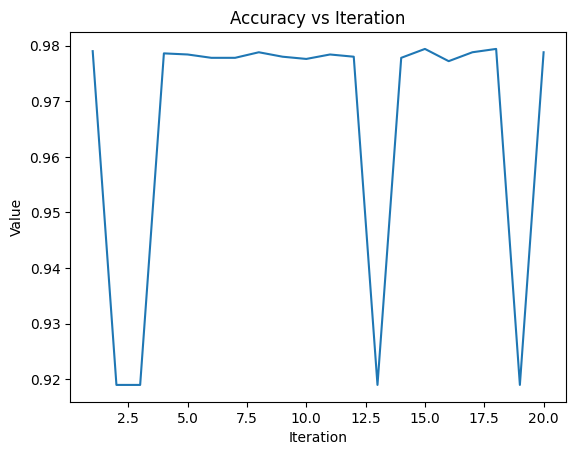

   Accuracy: 0.9794
 ROC-AUC: 0.9938465051921708


In [99]:
automl("XGBoost", "/kaggle/input/trainvlg/train.csv","credit_card_default")
automl_new("XGBoost", "/kaggle/input/trainvlg/train.csv","credit_card_default")